# Ham vs Spam Classifier

Predicts if an email is spam using multinomial naive bayes classifier.

## Multinomial Naive Bayes Classifier 

In [1]:
# Import relevant libraries
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

### Reading the database

In [2]:
# Read the youtube dataset
files = glob.glob("youtube-dataset\\*.csv")
files

['youtube-dataset\\Youtube01.csv',
 'youtube-dataset\\Youtube02.csv',
 'youtube-dataset\\Youtube03.csv',
 'youtube-dataset\\Youtube04.csv',
 'youtube-dataset\\Youtube05.csv']

In [3]:
all_df = []

# read all csv file into one list, and drop irrelevant columns
for i in files:
    all_df.append(pd.read_csv(i).drop(["COMMENT_ID", "AUTHOR", "DATE"], axis=1))

In [4]:
all_df[0]

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,watch?v=vtaRGgvGtWQ Check this out .﻿,1
4,"Hey, check out my new website!! This site is a...",1
...,...,...
344,How can this have 2 billion views when there's...,0
345,I don't now why I'm watching this in 2014﻿,0
346,subscribe to me for call of duty vids and give...,1
347,hi guys please my android photo editor downloa...,1


In [5]:
# Combine all samples from all the data frames into one dataframe

data = pd.concat(all_df, axis=0, ignore_index=True)
data

,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,watch?v=vtaRGgvGtWQ Check this out .﻿,1
4,"Hey, check out my new website!! This site is a...",1
...,...,...
1950,I love this song because we sing it at Camp al...,0
1951,I love this song for two reasons: 1.it is abou...,0
1952,wow,0
1953,Shakira u are so wiredo,0


### Data Cleaning

In [6]:
data.isnull().sum()

CONTENT    0
CLASS      0
dtype: int64

In [7]:
# Counts the number of hams and spams we have in the dataset, Spam = 1, Ham = 0
data["CLASS"].value_counts()

1    1004
0     951
Name: CLASS, dtype: int64

There are no null values in the data, and the data is almost balanced, hence we can proceed.

### Split Data

In [8]:
inputs = data["CONTENT"]
target = data["CLASS"]

In [9]:
# Split and Balance the dataset
x_train, x_test, y_train, y_test = train_test_split(inputs,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 45,
                                                    stratify = target)

In [10]:
y_train.value_counts(normalize = True)

1    0.513427
0    0.486573
Name: CLASS, dtype: float64

In [11]:
y_train.value_counts()

1    803
0    761
Name: CLASS, dtype: int64

### Tokenize the YouTube comments

In [12]:
# This converts a collection of text documents to a matrix of token counts.
vectorizer = CountVectorizer()

In [13]:
x_train_transf = vectorizer.fit_transform(x_train)
x_test_transf = vectorizer.transform(x_test)

In [14]:
x_train_transf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [15]:
x_train_transf.shape

(1564, 3828)

In [16]:
x_test_transf

<391x3828 sparse matrix of type '<class 'numpy.int64'>'
	with 4336 stored elements in Compressed Sparse Row format>

## Classification

In [17]:
clf = MultinomialNB(class_prior = np.array([0.6,0.4]))

In [18]:
clf.fit(x_train_transf, y_train)

MultinomialNB(class_prior=array([0.6, 0.4]))

In [19]:
# Handling unknown features
clf.get_params()

{'alpha': 1.0, 'class_prior': array([0.6, 0.4]), 'fit_prior': True}

In [20]:
np.exp(clf.class_log_prior_)

array([0.6, 0.4])

### Evaluate the test database

In [21]:
y_test_pred = clf.predict(x_test_transf)

In [22]:
clf.classes_

array([0, 1], dtype=int64)

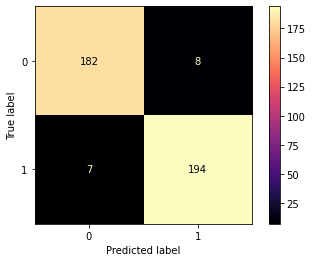

In [23]:
# Displays Confusion Matrix

sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(y_test,
                                       y_test_pred,
                                       labels = clf.classes_,
                                       cmap = "magma")

In [24]:
print(classification_report(y_test, y_test_pred, target_names=["Ham", "Spam"]))

              precision    recall  f1-score   support

         Ham       0.96      0.96      0.96       190
        Spam       0.96      0.97      0.96       201

    accuracy                           0.96       391
   macro avg       0.96      0.96      0.96       391
weighted avg       0.96      0.96      0.96       391



### Probability Distribution figures

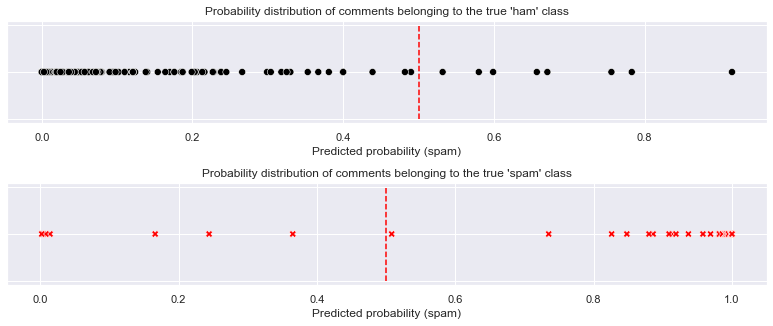

In [25]:
# For each ovservation, store its probability of being a spam. Round it to 3 digits after the decimal points.
# These probabilities will later serve as the x-coordinates of a scatter plot
spam_proba = clf.predict_proba(x_test_transf).round(3)[:,1];

# Create a new data frame which will store the true classes, the predicted classes and the predicted probability
# for an observation to belong to the spam class
df_scatter = pd.DataFrame()

# Create the columns of the data frame
df_scatter['True class'] = y_test
df_scatter['Predicted class'] = y_test_pred
df_scatter['Predicted probability (spam)'] = spam_proba

# Reset the index of the data frame, so that the indexing is sequential
df_scatter = df_scatter.reset_index(drop = True)

# Define two palettes for the different plots
palette_0 = sns.color_palette(['#000000'])
palette_1 = sns.color_palette(['#FF0000'])

# Create two new data frames. The first one stores the samples whose true class is 0.
# The second one stores the samples whose true class is 1.
df_scatter_0 = df_scatter[df_scatter['True class'] == 0].reset_index(drop = True)
df_scatter_1 = df_scatter[df_scatter['True class'] == 1].reset_index(drop = True)

# Set the seaborn style
sns.set()

# Create two subfigures, so that they are arranged in 2 rows and 1 column.
# Set the size of the figures
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5))
fig.tight_layout(pad = 3)

# Create a scatter plot.
# On the x-axis, we have the predicted probability of a comment being a spam.
# The y-axis takes only one value - zero. We create an array full of zeros having a length equal to 
# the number of samples whose true class is 0.
# The 'data' parameter specifies the dataset we are drawing the columns from.
# The 'hue' parameter specifies the feature based on which the points are going to be colored. In this case,
# this feature has only a single class - the 0 class.
# The 's' parameter specifies the size of the points.
# The 'markers' parameter determines the shape of the points.
# The 'palette' parameter specifies the colors to be used in the plot.
# The 'style' parameter connects markers to classes.
# We have decided to set the 'legend' parameter equal to False as we have only one class in the plot. 
# We decide to remove the ticks from the y-axis as they can be chosen arbitrarily.
sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_0.shape[0]), 
                data = df_scatter_0,
                hue = 'True class', 
                s = 50,
                markers = ['o'],
                palette = palette_0,
                style = 'True class',
                legend = False, 
                ax = ax1).set(yticklabels=[])

# Set a title above the first plot.
ax1.set_title('Probability distribution of comments belonging to the true \'ham\' class')

# Create a red vertical dashed line passing through the point x = 0.5
# The first parameter specifies the x-coordinate.
# The second and third parameters specify the min and the max y-coordinates.
# We choose a dashed linestyle.
# We color the line in red.
ax1.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');

# The comments above apply to this plot. The code is adapted to the spam class
sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_1.shape[0]), 
                hue = 'True class', 
                data = df_scatter_1,
                s = 50,
                palette = palette_1,
                markers = ['X'],
                style = 'True class',
                legend = False, 
                ax = ax2).set(yticklabels=[])

# Set a title above the second plot.
ax2.set_title('Probability distribution of comments belonging to the true \'spam\' class')

# Create a red vertical dahsed line for the second plot
ax2.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');

## Making Predictions

In [26]:
predict_data = vectorizer.transform(["This song is amazing", "You can win 1m dollars right now, just clikc here!!!"])

In [27]:
clf.predict(predict_data)

array([0, 1], dtype=int64)